In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import asyncio
import os
import pandas as pd
import numpy as np

from hfppl.modeling import Model
from hfppl.distributions import LMContext, TokenCategorical
from hfppl.llms import CachedCausalLM
from hfppl.inference import smc_standard

from battleship.board import Board
from battleship.scoring import compute_score

In [4]:
# Load HF_AUTH_TOKEN from .hf_auth_token
with open(os.path.join("../", ".hf_auth_token"), "r") as f:
    os.environ["HF_AUTH_TOKEN"] = f.read().strip()

HF_AUTH_TOKEN = os.environ["HF_AUTH_TOKEN"]

In [5]:
# Initialize the HuggingFace model
lm = CachedCausalLM.from_pretrained("codellama/CodeLlama-7b-hf", auth_token=HF_AUTH_TOKEN)

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


# Battleship model

In [6]:
df = pd.read_csv("../battleship/prompts/examples.csv")

def format_example(user_input: str, response: str = None):
    return f"User: {user_input}\n" f"Assistant:{' ' + response if response else ''}"

def make_question_prompt(df):
    prompt = "\n".join(df.question) + "\n"
    return prompt

def make_question_to_code_prompt(df):
    prompt = "\n".join([format_example(q, r) for q, r in zip(df.question, df.code)]) + "\n"
    return prompt

In [7]:
print(make_question_prompt(df))

How many blocks is the red ship?
Does the purple ship have 4 tiles?
Is the purple ship horizontal or vertical?
Does the purple ship go upwards?
What is at B1?
Is there a ship at F3?
Is the purple ship touching the blue ship?
What are the coordinate of the first block of the red ship?
What is the rightmost square occupied by the purple ship?
Are any of the ships horizontal?
How many ships are vertical?
How many total squares are occupied by ships?



In [8]:
print(make_question_to_code_prompt(df))

User: How many blocks is the red ship?
Assistant: (size Red)
User: Does the purple ship have 4 tiles?
Assistant: (== (size Purple) 4)
User: Is the purple ship horizontal or vertical?
Assistant: (orient Purple)
User: Does the purple ship go upwards?
Assistant: (== (orient Purple) V)
User: What is at B1?
Assistant: (color B-1)
User: Is there a ship at F3?
Assistant: (not (== (color F-3) Water))
User: Is the purple ship touching the blue ship?
Assistant: (touch Purple Blue)
User: What are the coordinate of the first block of the red ship?
Assistant: (topleft (coloredTiles Red))
User: What is the rightmost square occupied by the purple ship?
Assistant: (bottomright (coloredTiles Purple))
User: Are any of the ships horizontal?
Assistant: (any (map (lambda x0 (== (orient x0) H)) (set AllColors)))
User: How many ships are vertical?
Assistant: (++ (map (lambda x0 (== (orient x0) V)) (set AllColors)))
User: How many total squares are occupied by ships?
Assistant: (++ (map (lambda x0 (size x0)) 

In [21]:
class QuestionGenerationModel(Model):
    def __init__(self, lm: CachedCausalLM, board: Board, question_prompt: str, translation_prompt: str, n_rollouts: int = 3, max_tokens: int = 32):
        super().__init__()
        self.lm = lm
        self.context = LMContext(lm, question_prompt)

        self.board = board

        self.question_prompt = question_prompt
        self.translation_prompt = translation_prompt

        self.n_rollouts = n_rollouts
        self.max_tokens = max_tokens

    async def step(self):

        token = await self.sample(self.context.next_token())

        results = await asyncio.gather(*[self.rollout(str(self.context)) for _ in range(self.n_rollouts)])
        score_mean = np.mean([result["score"] for result in results])
        # self.twist(score_mean)
        self.score(score_mean)

        print(f"Partial question: {str(self.context)}")
        print(f"|- Score mean: {score_mean:.4f}")
        print(f"|- Particle weight: {self.weight:.4f}")
        for result in results:
            print(f"  |- Completion: {result['completion']}")
            print(f"    |- Translation: {result['translation']}")
            print(f"    |- Score: {result['score']:.4f}")
        print()

        if self.is_final_token(token) or self.is_final_context(self.context):
            translation = await self._translate_question(str(self.context))
            score = compute_score(board=self.board, program=translation)
            self.condition(score > 0)
            self.finish()

    async def rollout(self, question: str):
        completion = await self._complete_question(question)
        translation = await self._translate_question(completion)
        score = compute_score(board=self.board, program=translation)
        return {"completion": completion, "translation": translation, "score": score}

    async def _complete_question(self, question: str, temp: float = 0.7):
        # Complete the question
        ctx = LMContext(self.lm, self.question_prompt + question, temp=temp)
        for _ in range(self.max_tokens):
            token = await self.sample(ctx.next_token())
            if self.is_final_token(token):
                break
            if self.is_final_context(ctx):
                break
        completion = question + str(ctx).split("\n")[0]
        completion = completion.strip()
        return completion

    async def _translate_question(self, completion: str, temp: float = 0.1):
        # Translate the question to code
        ctx = LMContext(self.lm, self.translation_prompt + format_example(completion), temp=temp)
        for _ in range(self.max_tokens):
            token = await self.sample(ctx.next_token())
            if self.is_final_token(token, include_punctuation=False):
                break
            if self.is_final_context(ctx):
                break
        translation = str(ctx).split("\n")[0]
        translation = translation.strip()
        return translation

    def is_final_token(self, token, include_punctuation: bool = True, include_newline: bool = True):
        if token.token_id == self.lm.tokenizer.eos_token_id:
            return True
        if include_punctuation and str(token) in ['.', '!', '?']:
            return True
        if include_newline and str(token) in ['\n']:
            return True
        return False

    def is_final_context(self, context):
        if "\n" in str(context):
            return True

    def immutable_properties(self):
        return set([])

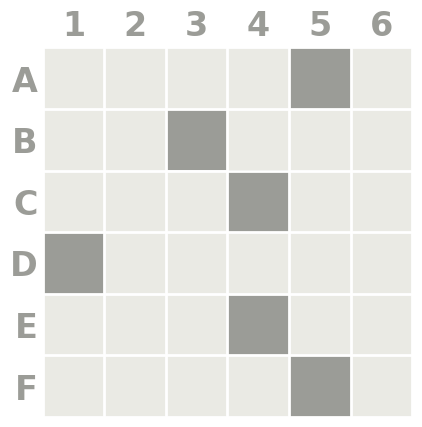

In [22]:
board = Board.from_trial_id(1)
board

In [23]:
# Create a model instance
model = QuestionGenerationModel(
    lm=lm,
    board=board,
    question_prompt=make_question_prompt(df),
    translation_prompt=make_question_to_code_prompt(df),
)

In [24]:
particles = await smc_standard(model, n_particles=3)


Partial question: Draw
|- Score mean: 0.0000
|- Particle weight: 0.0000
  |- Completion: Draw the board, as you imagine it.
    |- Translation: (drawBoard)
    |- Score: 0.0000
  |- Completion: Draw a picture of the ships.
    |- Translation: (drawShips)
    |- Score: 0.0000
  |- Completion: Draw the blue ship.
    |- Translation: (draw (coloredTiles Blue))
    |- Score: 0.0000

Partial question: Can
|- Score mean: 0.0000
|- Particle weight: 0.0000
  |- Completion: Can the purple ship be moved?
    |- Translation: (canMove Purple)
    |- Score: 0.0000
  |- Completion: Can the red ship go over the ship at C3?
    |- Translation: (not (touch Red C-3))
    |- Score: 0.0000
  |- Completion: Can the blue ship be moved to the right?
    |- Translation: (canMove Blue R)
    |- Score: 0.0000

Partial question: How
|- Score mean: 1.4426
|- Particle weight: 1.4426
  |- Completion: How many ships are touching the red ship?
    |- Translation: (++ (map (lambda x0 (touch x0 Red)) (set AllColors)))


/home/ubuntu/battleship/hfppl/hfppl/util.py:7: RuntimeWarning: invalid value encountered in subtract
  return np.log(np.sum(np.exp(nums - m))) + m


In [25]:
[(round(p.weight, 4), str(p.context)) for p in particles]

[(-inf, 'Can 5133 be divided by 2233?'),
 (-inf, 'Can 5133 be divided by 2230?'),
 (-inf, 'Can 5133 be divided by 223?')]